In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim,jieba,os


In [2]:
df = pd.read_csv('cleandemo7.csv')
# del df['Unnamed: 0']
df.head(2)

,sessionid,request,response
0,13410000258T16081911402229APP,实名制了怎么还不能打电话？,请问是本机吗？我帮您开机，请稍等哈
1,13410000422T16082318212113APP,查询我现在的套餐,，您改了38元4G飞享套餐，9-13号生效哦，还在线吗，还有其他可以帮到您吗？


for sentences:
    sentence.cut()
    looking_up-> vec
kmeans or lda
GRU

# 词向量模型

In [3]:
from gensim.models import Word2Vec
# w = Word2Vec.load('./mymodel_pub')
# w = gensim.models.KeyedVectors.load_word2vec_format('./news_12g_baidubaike_20g_novel_90g_embedding_64.bin',binary=True)
w =  Word2Vec.load('./self_train_word2vec')

In [4]:
sens_vec = []
black = np.array([0]*w['话费'].shape[0])
for sen in df.response:
    sen = [vec for vec in jieba.cut(sen)]
    sen_array = [w[i] if i in w else black for i in sen]
    sens_vec.append(sum(sen_array)/float(len(sen_array)))
    


/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/ny/f3f_tg0j5pl8mzvdvjd8258c0000gn/T/jieba.cache
Loading model cost 1.010 seconds.
Prefix dict has been built succesfully.
/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# 聚类

In [5]:
from sklearn.cluster import KMeans
k = 7
clf = KMeans(n_clusters=k) #设定k，这里就是调用KMeans算法 
s = clf.fit(sens_vec) #加载数据集合 
numSamples = len(sens_vec) 
centroids = clf.labels_
print(centroids) #显示中心点
print(clf.inertia_)  #显示聚类效果
# print(clf.cluster_centers_) #簇的中心向量

[2 3 2 ... 1 5 1]
26458.73619671407


In [6]:
df_cluster = pd.concat((df,pd.DataFrame(clf.labels_,columns = ['cluster'])),axis = 1)
print(df_cluster.shape)
df_cluster.head()

(6132, 4)


,sessionid,request,response,cluster
0,13410000258T16081911402229APP,实名制了怎么还不能打电话？,请问是本机吗？我帮您开机，请稍等哈,2
1,13410000422T16082318212113APP,查询我现在的套餐,，您改了38元4G飞享套餐，9-13号生效哦，还在线吗，还有其他可以帮到您吗？,3
2,13410001228T160803125048,我前天办的飞享套餐，我要取消38元的,，请问是在什么时候办理的呢,2
3,13410001228T160803125048,电话办理的,您是不是之前要求取消了呢？,2
4,13410001228T160803125048,是的，我要求取消的昨天你们客服打电话来，我没接到,显示订单回退了，就是承诺使用38元套餐2个月的那个订单,3


In [7]:
df_cluster[df_cluster.cluster ==5][:4]

,sessionid,request,response,cluster
6,13410001228T160803125048,只要那个38元的套餐取消了就不用了,可以帮您添加中途意见哦,5
7,13410001228T160803125048,已经取消了就可以了,具体处理结果还没显示哦,5
8,13410001228T160803125048,现在还没生效，不就马上可以取消吗？,处理方案：复用户无人接听，考虑目前还没有生效，我处已特殊取消了此方案，目前还没有录入转套餐的...,5
12,13410001228T160807211011,小和要火上月抢到的流量什么时候派送,，本月底前为您赠送的,5


In [8]:
df_cluster.groupby('cluster').count()

,sessionid,request,response
cluster,,,
0,561,561,561
1,757,757,757
2,1039,1039,1039
3,920,920,920
4,608,608,608
5,1936,1936,1936
6,311,311,311


# save as txt file

In [9]:
w.wv.save_word2vec_format('./wordvec_news.txt', binary=False)

In [10]:
df_cluster.to_csv('./df_cluster.csv',index=False)

# 衡量ground truth

In [11]:
df_labeled = pd.read_csv('./data_labeled_2.csv')
print(df_labeled.shape)
df_labeled.head(2)

(93, 5)


,index,sessionid,request,domain,intention
0,227,13410022560T160817102657,你好，能帮我开通国际漫游吗,漫游,漫游办理
1,516,13410061331T16082619274909APP,所以我的号每个月都要扣多少钱呢,通话,话费查询


In [14]:
df_labeled.groupby('domain').count()

,index,sessionid,request,intention
domain,,,,
业务,3,3,3,3
套餐,30,30,30,30
宽带,2,2,2,2
流量,40,40,40,40
漫游,3,3,3,3
积分,2,2,2,2
通话,13,13,13,13


In [13]:
df_cluster_labeled = pd.merge(df_cluster,df_labeled)
print(df_cluster_labeled.shape)
df_cluster_labeled.head(3)

(65, 7)


,sessionid,request,response,cluster,index,domain,intention
0,13410000422T16082318212113APP,查询我现在的套餐,，您改了38元4G飞享套餐，9-13号生效哦，还在线吗，还有其他可以帮到您吗？,3,1,套餐,套餐查询
1,13410001228T160807211011,流量不清零的介绍,流量不清零服务：所有包含流量并按月计费的主套餐（不含4G随心王）、手机流量套餐、闲时套餐，当...,6,17,流量,流量介绍
2,13410001228T160807211011,能否帮我查下现在用的是不是六块月租的,，您现在是6元的月租的轻松卡的套餐的,3,19,套餐,套餐查询


## 评价指标

In [15]:
df_cluster_labeled.domain.unique().shape[0]

6

In [16]:
df_cluster_labeled.groupby('domain').count()

,sessionid,request,response,cluster,index,intention
domain,,,,,,
业务,1,1,1,1,1,1
套餐,23,23,23,23,23,23
流量,30,30,30,30,30,30
漫游,2,2,2,2,2,2
积分,1,1,1,1,1,1
通话,8,8,8,8,8,8


In [17]:
# sklearn.metrics.homogeneity_score:每一个聚出的类仅包含一个类别的程度度量。
# sklearn.metrics.completeness:每一个类别被指向相同聚出的类的程度度量。
from sklearn import metrics
labels_true = df_cluster_labeled.domain
labels_pred = df_cluster_labeled.cluster
print(metrics.adjusted_rand_score(labels_true, labels_pred)  )
print(metrics.homogeneity_score(labels_true, labels_pred)  )


0.0578923281988779
0.24387597871741262


聚类的id进行随机分配

In [18]:

labels_true = df_cluster_labeled.domain
# labels_pred = df_cluster_labeled.cluster.sample(n=df_cluster_labeled.shape[0])
labels_pred = df_cluster_labeled.domain.sample(n=df_cluster_labeled.shape[0])
print(metrics.adjusted_rand_score(labels_true, labels_pred)  )
print(metrics.homogeneity_score(labels_true, labels_pred)  )

0.0017917240970007286
0.16134521281235562


In [57]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 0, 1, 1, 2]
metrics.adjusted_rand_score(labels_true, labels_pred)

0.7058823529411765

## 对labeled数据进行聚类

In [39]:
sens_vec_labeld = []
black = np.array([0]*w['词'].shape[0])
for sen in df_labeled.response:
    sen = [vec for vec in jieba.cut(sen)]
    sen_array = [w[i] if i in w else black for i in sen]
    sens_vec_labeld.append(sum(sen_array)/float(len(sen_array)))

AttributeError: 'DataFrame' object has no attribute 'response'

In [ ]:
s = clf.predict(sens_vec_labeld) #加载数据集合
numSamples = len(sens_vec_labeld) 
centroids = clf.labels_
print(centroids) #显示中心点
print(clf.inertia_)  #显示聚类效果
df_cluster_labeled = pd.concat((df_labeled,pd.DataFrame(clf.labels_,columns = ['cluster'])),axis = 1)
print(df_cluster_labeled.shape)
df_cluster_labeled.head()

In [55]:
df_cluster_labeled.groupby(['cluster','domain',]).count()

sessionid  request  response  index  intention
cluster domain                                                
0       套餐              7        7         7      7          7
        流量              3        3         3      3          3
        积分              1        1         1      1          1
1       套餐              1        1         1      1          1
        流量              7        7         7      7          7
        通话              1        1         1      1          1
2       套餐              8        8         8      8          8
        流量             10       10        10     10         10
        通话              2        2         2      2          2
3       业务              1        1         1      1          1
        套餐              2        2         2      2          2
        流量              1        1         1      1          1
        通话              1        1         1      1          1
4       套餐              1        1         1      1          1
        通话              1        1         1      1          1
5       套餐              1        1         1      1          1
        流量              1        1         1      1          1
        漫游              1        1         1      1          1
6       套餐              1        1         1      1          1
        流量              2        2         2      2          2

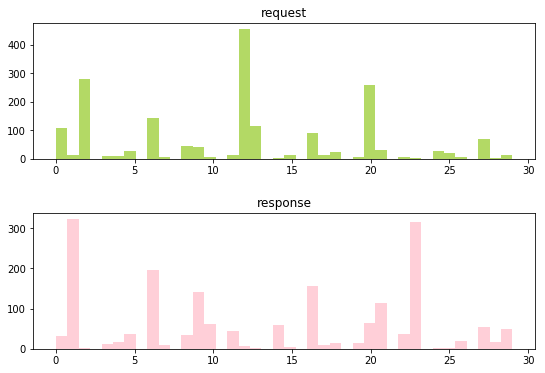

In [31]:
def cluster(feature_name, k):
    sens_vec = []
    black = np.array([0]*w['词'].shape[0])
    for sen in df.response:
        sen = [vec for vec in jieba.cut(sen)]
        sens_vec.append(sum([w[i] if i in w else black for i in sen]))
    clf = KMeans(n_clusters=k) #设定k，这里就是调用KMeans算法
    s = clf.fit(sens_vec) #加载数据集合
#     numSamples = len(sens_vec) 
#     centroids = clf.labels_
    df_cluster = pd.concat((df,pd.DataFrame(clf.labels_,columns = ['cluster'])),axis = 1)
    return clf, df_cluster

clf_reponse, cluster_response = cluster('response', 30)
clf_request, cluster_request = cluster('request', 30)

fig,(ax0,ax1) = plt.subplots(nrows=2,figsize=(9,6)) 
ax0.hist(cluster_request.cluster,40,histtype='bar',facecolor='yellowgreen',alpha=0.75)
ax0.set_title('request')
ax1.hist(cluster_response.cluster,40,histtype='bar',facecolor='pink',alpha=0.75,) 
ax1.set_title("response") 
fig.subplots_adjust(hspace=0.4) 
plt.show()